
# IE4414 Team 4
***
**Team members:** 

1. MUHAMMAD SHAFIQ B NINABA
2. MUHAMMAD DANISH BIN MOHAMAD NASIR
3. NG SHENG FENG
4. LUO RUIQI
5. LIU MOJIA
6. LIM XIN YI IRIS

**Food categories:**<br>
<br>0. Bak Chor Mee <br>4. Kaya Toast and Egg <br>6. Nasi Lemak <br>7. Oyster Omelette <br>8. Roti Prata <br>9. Satay <br>

***

## Table of Contents
1. [Loading data](#1.-loading-data)
2. [Visualizing the dataset](#2.-visualizing-the-dataset)
3. [Defining function to train the model](#3.-defining-function-to-train-the-model)
4. [Training and validating the model](#4.-training-and-validating-the-model)
5. [Loading test data](#5.-loading-test-data)
6. [Visualizing the predictions](#6.-visualizing-the-predictions)
7. [Evaluating on test set](#7.-evaluating-on-test-set)
8. [Advanced Requirements](#8.-advanced-requirements)

***

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchsummary import summary
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Global Variables
data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}
selected_classes = [0,4,6,7,9,10]
n_classes = len(selected_classes)
num_epochs = 5

***

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [4]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [5]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}


# Define the dataset
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 4, 6, 7, 9, 10]
    name: ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']


***

## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them.



In [6]:
dataloaders['train'].dataset.classes

['Bak Chor Mee',
 'Kaya Toast and Egg',
 'Nasi Lemak',
 'Oyster Omelette',
 'Roti Prata',
 'Satay']

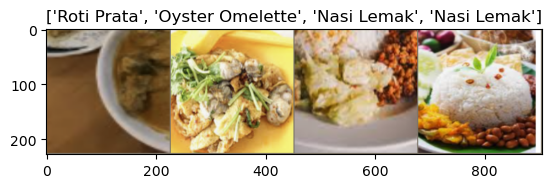

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

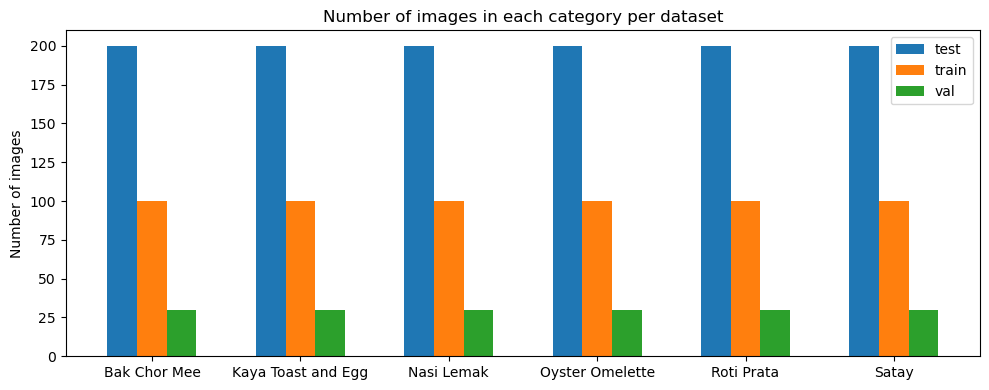

In [8]:
import os
import matplotlib.pyplot as plt

data_dir = 'data/sg_food'
datasets = ['test', 'train', 'val']
categories = ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']

# Count the number of images in each category for each dataset
counts = {dataset: {category: len(os.listdir(os.path.join(data_dir, dataset, category))) for category in categories} for dataset in datasets}

# Plot the distributions
fig, ax = plt.subplots(figsize=(10, 4))

width = 0.2  # width of the bars
x = range(len(categories))  # x coordinates of the bars

for i, (dataset, count) in enumerate(counts.items()):
    ax.bar([p + width*i for p in x], count.values(), width=width, label=dataset)

ax.set_xticks([p + width for p in x])
ax.set_xticklabels(categories)
ax.set_ylabel('Number of images')
ax.legend()

plt.title('Number of images in each category per dataset')
plt.tight_layout()
plt.show()

***

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [9]:
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Initialize lists to keep track of loss and accuracy for each epoch
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Record the loss and accuracy history
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc.item())
                else:
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Return a list containing the training and validation loss and accuracy for each epoch
    return model, [train_loss_history, train_acc_history, val_loss_history, val_acc_history]

***

## 4. Training and validating the models



### Model 1: CNN From Scratch

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1) #input, output, kernel size 3x3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
import torch.optim as optim

criterion_cnn_scratch = nn.CrossEntropyLoss()
optimizer_cnn_scratch = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_cnn_scratch = lr_scheduler.StepLR(optimizer_cnn_scratch, step_size=7, gamma=0.1)

In [12]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [13]:
from torchsummary import summary

summary(net, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            168
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            880
├─Linear: 1-4                            6,021,240
├─Linear: 1-5                            10,164
├─Linear: 1-6                            510
Total params: 6,032,962
Trainable params: 6,032,962
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            168
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            880
├─Linear: 1-4                            6,021,240
├─Linear: 1-5                            10,164
├─Linear: 1-6                            510
Total params: 6,032,962
Trainable params: 6,032,962
Non-trainable params: 0

In [14]:
model_cnn_scratch, losses_cnn_scratch = train_model(net, criterion_cnn_scratch, optimizer_cnn_scratch, exp_lr_scheduler_cnn_scratch, num_epochs)

Epoch 0/4
----------
train Loss: 1.7940 Acc: 0.1667
val Loss: 1.7920 Acc: 0.1667

Epoch 1/4
----------
train Loss: 1.7910 Acc: 0.1667
val Loss: 1.7876 Acc: 0.1611

Epoch 2/4
----------
train Loss: 1.7880 Acc: 0.1783
val Loss: 1.7823 Acc: 0.2167

Epoch 3/4
----------
train Loss: 1.7830 Acc: 0.2067
val Loss: 1.7747 Acc: 0.2111

Epoch 4/4
----------


train Loss: 1.7749 Acc: 0.2000
val Loss: 1.7647 Acc: 0.2278

Training complete in 0m 31s
Best val Acc: 0.227778


### Model 2: ResNet

In [15]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv_resnet = models.resnet101(pretrained=True)

for param in model_conv_resnet.parameters():
    param.requires_grad = False

# 2. Modify the pretrain model for your task.

num_ftrs = model_conv_resnet.fc.in_features
model_conv_resnet.fc = nn.Linear(num_ftrs, 6)

model_conv_resnet = model_conv_resnet.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_conv_resnet.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)


In [16]:
print(model_conv_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
from torchsummary import summary
summary(model_conv_resnet, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [18]:
model_resnet, losses_resnet = train_model(model_conv_resnet, criterion_resnet, optimizer_resnet, exp_lr_scheduler_resnet, num_epochs)

Epoch 0/4
----------


train Loss: 1.6402 Acc: 0.3250
val Loss: 1.2789 Acc: 0.4833

Epoch 1/4
----------
train Loss: 1.1976 Acc: 0.5400
val Loss: 0.6986 Acc: 0.7444

Epoch 2/4
----------
train Loss: 0.8654 Acc: 0.6750
val Loss: 0.8477 Acc: 0.7056

Epoch 3/4
----------
train Loss: 0.8474 Acc: 0.6867
val Loss: 0.6209 Acc: 0.8000

Epoch 4/4
----------
train Loss: 0.6609 Acc: 0.7750
val Loss: 0.6040 Acc: 0.8167

Training complete in 6m 46s
Best val Acc: 0.816667


### Model 3: VGG16

In [19]:
model_conv_vgg = models.vgg16(pretrained=True)
for param in model_conv_vgg.parameters():
    param.requires_grad = False
# 2. Modify the pretrain model for your task.

num_ftrs = model_conv_vgg.classifier[6].in_features
model_conv_vgg.classifier[6] = nn.Linear(num_ftrs, 6)  # 将最后一个全连接层替换为新的线性层，输出 6 个类别

model_conv_vgg = model_conv_vgg.to(device)

# 3. Choose your loss function, optimizer, etc.

import torch.optim as optim

criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(model_conv_vgg.classifier[6].parameters(), lr=0.001, momentum=0.9)  # 只优化新的分类层
exp_lr_scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)  # 每7个周期调整学习率


In [20]:
print(model_conv_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:

summary(model_conv_vgg, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

In [22]:
model_vgg, losses_vgg = train_model(model_conv_vgg, criterion_vgg, optimizer_vgg, exp_lr_scheduler_vgg, num_epochs)

Epoch 0/4
----------


train Loss: 1.7841 Acc: 0.2150
val Loss: 1.4711 Acc: 0.5000

Epoch 1/4
----------
train Loss: 1.4043 Acc: 0.4767
val Loss: 1.0206 Acc: 0.7722

Epoch 2/4
----------
train Loss: 1.1052 Acc: 0.6233
val Loss: 0.7990 Acc: 0.7889

Epoch 3/4
----------
train Loss: 0.9787 Acc: 0.6517
val Loss: 0.6798 Acc: 0.8222

Epoch 4/4
----------
train Loss: 0.8758 Acc: 0.7233
val Loss: 0.6181 Acc: 0.8222

Training complete in 7m 55s
Best val Acc: 0.822222


### Model 4: DenseNet

In [23]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv_densenet= models.densenet121(pretrained=True)
for param in model_conv_densenet.parameters():
    param.requires_grad = False

# 2. Modify the pretrain model for your task.

num_ftrs = model_conv_densenet.classifier.in_features
model_conv_densenet.classifier = nn.Linear(num_ftrs, 6)

model_conv_densenet = model_conv_densenet.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = optim.SGD(model_conv_densenet.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_densenet = lr_scheduler.StepLR(optimizer_densenet, step_size=7, gamma=0.1)


In [24]:
print(model_conv_densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
summary(model_conv_densenet, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |

In [26]:
model_densenet, losses_densenet = train_model(model_conv_densenet, criterion_densenet, optimizer_densenet, exp_lr_scheduler_densenet, num_epochs)

Epoch 0/4
----------


train Loss: 1.8237 Acc: 0.1933
val Loss: 1.7440 Acc: 0.2333

Epoch 1/4
----------
train Loss: 1.6959 Acc: 0.3267
val Loss: 1.5896 Acc: 0.4667

Epoch 2/4
----------
train Loss: 1.5707 Acc: 0.4417
val Loss: 1.4394 Acc: 0.5778

Epoch 3/4
----------
train Loss: 1.4251 Acc: 0.5733
val Loss: 1.3022 Acc: 0.7000

Epoch 4/4
----------
train Loss: 1.3158 Acc: 0.6400
val Loss: 1.1942 Acc: 0.7000

Training complete in 4m 35s
Best val Acc: 0.700000


### Model 5: Inception

There were some issues integrating the Inception model with this notebook. The Inception code is appended at the [end of this notebook](#Model-5:-InceptionV3)

### Model 6: MobileNetV3

#### 4.1 Loading pretrained model and defining new classfier layer


In [27]:
import torchvision.models
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv_mobilenet = torchvision.models.mobilenet_v3_large(pretrained=True)
for param in model_conv_mobilenet.parameters():
    param.requires_grad = False


# 2. Modify the pretrain model for your task.

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_mobilenet.classifier[3].in_features
model_conv_mobilenet.classifier[3] = nn.Linear(num_ftrs, len(selected_classes))

model_conv_mobilenet = model_conv_mobilenet.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion_mobilenet = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mobilenet = optim.SGD(model_conv_mobilenet.classifier[3].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_mobilenet = lr_scheduler.StepLR(optimizer_mobilenet, step_size=7, gamma=0.1)


In [28]:
print(model_conv_mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [29]:
summary(model_conv_mobilenet, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 7, 7]           --
|    └─ConvNormActivation: 2-1                [-1, 16, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 16, 112, 112]        (432)
|    |    └─BatchNorm2d: 3-2                  [-1, 16, 112, 112]        (32)
|    |    └─Hardswish: 3-3                    [-1, 16, 112, 112]        --
|    └─InvertedResidual: 2-2                  [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                   [-1, 16, 112, 112]        (464)
|    └─InvertedResidual: 2-3                  [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                   [-1, 24, 56, 56]          (3,440)
|    └─InvertedResidual: 2-4                  [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                   [-1, 24, 56, 56]          (4,440)
|    └─InvertedResidual: 2-5                  [-1, 40, 28, 28]          --
| 

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 960, 7, 7]           --
|    └─ConvNormActivation: 2-1                [-1, 16, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 16, 112, 112]        (432)
|    |    └─BatchNorm2d: 3-2                  [-1, 16, 112, 112]        (32)
|    |    └─Hardswish: 3-3                    [-1, 16, 112, 112]        --
|    └─InvertedResidual: 2-2                  [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                   [-1, 16, 112, 112]        (464)
|    └─InvertedResidual: 2-3                  [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                   [-1, 24, 56, 56]          (3,440)
|    └─InvertedResidual: 2-4                  [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                   [-1, 24, 56, 56]          (4,440)
|    └─InvertedResidual: 2-5                  [-1, 40, 28, 28]          --
| 

In [30]:
model_mobilenet, losses_mobilenet = train_model(model_conv_mobilenet, criterion_mobilenet, optimizer_mobilenet, exp_lr_scheduler_mobilenet,num_epochs)

Epoch 0/4
----------


train Loss: 1.8365 Acc: 0.1750
val Loss: 1.8336 Acc: 0.1889

Epoch 1/4
----------
train Loss: 1.7330 Acc: 0.2483
val Loss: 1.6902 Acc: 0.3222

Epoch 2/4
----------
train Loss: 1.5976 Acc: 0.4100
val Loss: 1.5360 Acc: 0.4833

Epoch 3/4
----------
train Loss: 1.4780 Acc: 0.5383
val Loss: 1.3897 Acc: 0.6389

Epoch 4/4
----------
train Loss: 1.3871 Acc: 0.5933
val Loss: 1.2686 Acc: 0.6833

Training complete in 1m 28s
Best val Acc: 0.683333


Saving the models into a dictionary for evaluation later on.

In [31]:
model_dict = {'MobileNetV3':[model_mobilenet, losses_mobilenet], 'CNN From Scratch':[model_cnn_scratch, losses_cnn_scratch], 'ResNet101':[model_resnet, losses_resnet], 'VGG16':[model_vgg, losses_vgg], 'DenseNet121':[model_densenet, losses_densenet]}

***

## 5. Loading test data

Define the dataset and dataloader for testing.

In [32]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

***

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

In [33]:
def run_inference(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted:{class_names[preds[j]]}\ntrue:{class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return all_preds, all_labels
        model.train(mode=was_training)

----------------------------------Inference result of MobileNetV3-----------------------------------


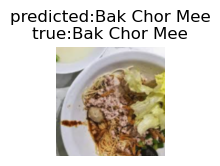

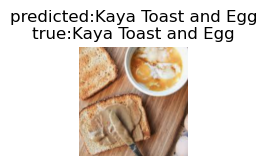

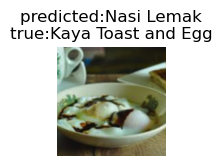

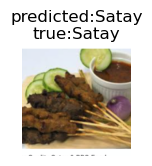

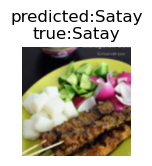

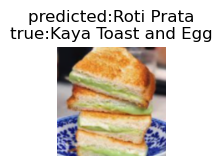

--------------------------------Inference result of CNN From Scratch--------------------------------


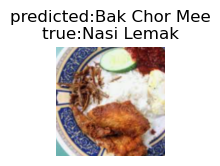

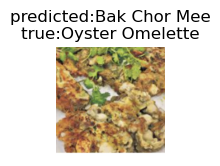

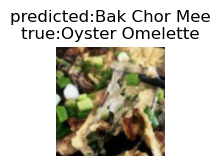

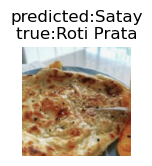

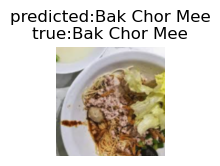

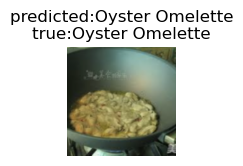

-----------------------------------Inference result of ResNet101------------------------------------


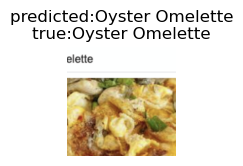

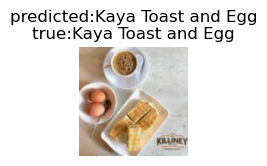

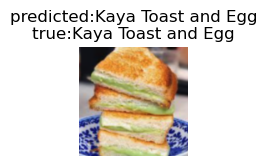

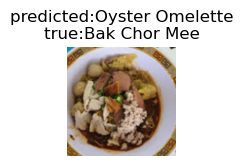

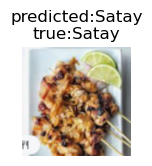

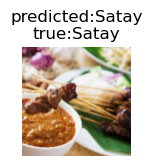

-------------------------------------Inference result of VGG16--------------------------------------


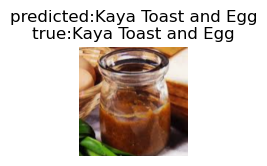

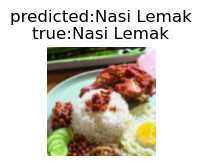

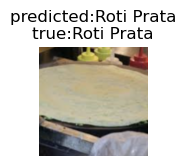

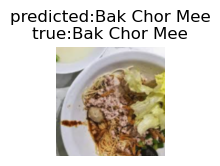

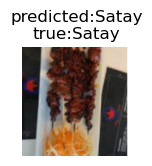

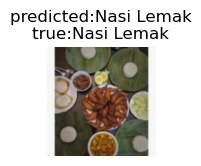

----------------------------------Inference result of DenseNet121-----------------------------------


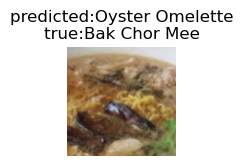

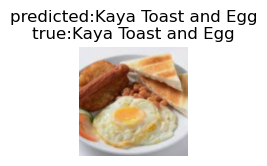

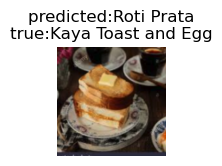

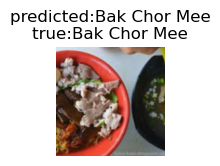

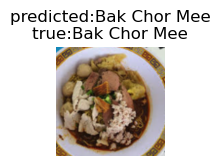

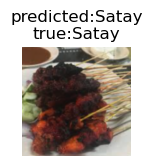

In [34]:
for model in model_dict:
    print(f'Inference result of {model}'.center(100,'-'))
    run_inference(model_dict[model][0], num_images=6)

***

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [35]:
for model in model_dict:
    model_dict[model][0].eval()

    test_acc = 0

    print(f'Evaluation for {model}'.center(40,'-'))

    all_preds = []
    all_labels = []

    with torch.no_grad():
        # Iterate over the testing dataset.
        for (inputs, labels) in test_loader:
            inputs = inputs.to(device)
            # Predict on the test set
            outputs = model_dict[model][0](inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            test_acc += torch.sum(preds == labels.data)

            # Save the predictions and labels
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # insert the predictions and labels into the model list
    model_dict[model].append([all_preds, all_labels])
    # Compute the testing accuracy
    test_acc = test_acc.double() / test_sizes
    print('Testing Acc: {:.4f}'.format(test_acc))

-------Evaluation for MobileNetV3-------


Testing Acc: 0.7158
----Evaluation for CNN From Scratch-----
Testing Acc: 0.2275
--------Evaluation for ResNet101--------
Testing Acc: 0.7833
----------Evaluation for VGG16----------
Testing Acc: 0.7950
-------Evaluation for DenseNet121-------
Testing Acc: 0.6892


In [36]:
# ensure that the train functions include the loss and accuracy history
# plot a graph to show the training and validation loss
def plot_loss(model_name, train_loss, val_loss):
    plt.figure()
    plt.title(model_name + ' Loss')
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'reports/{model_name}_loss.png')
    plt.show()

# plot a graph to show the training and validation accuracy
def plot_acc(model_name, train_acc, val_acc):
    plt.figure()
    plt.title(model_name + ' Accuracy')
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'reports/{model_name}_accuracy.png')
    plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model_name, all_preds, all_labels, class_names=class_names):
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'reports/{model_name}_confusion_matrix.png')


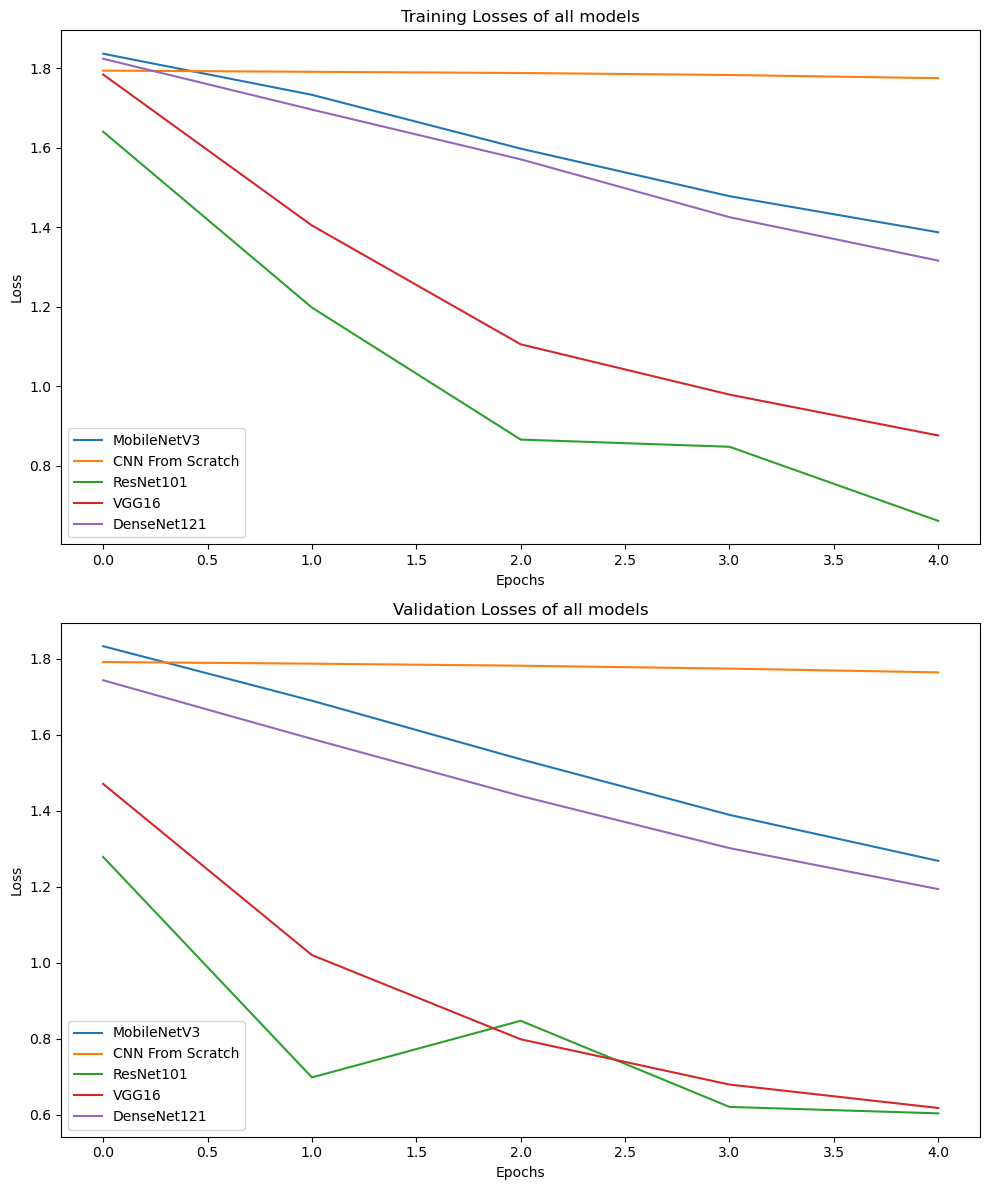

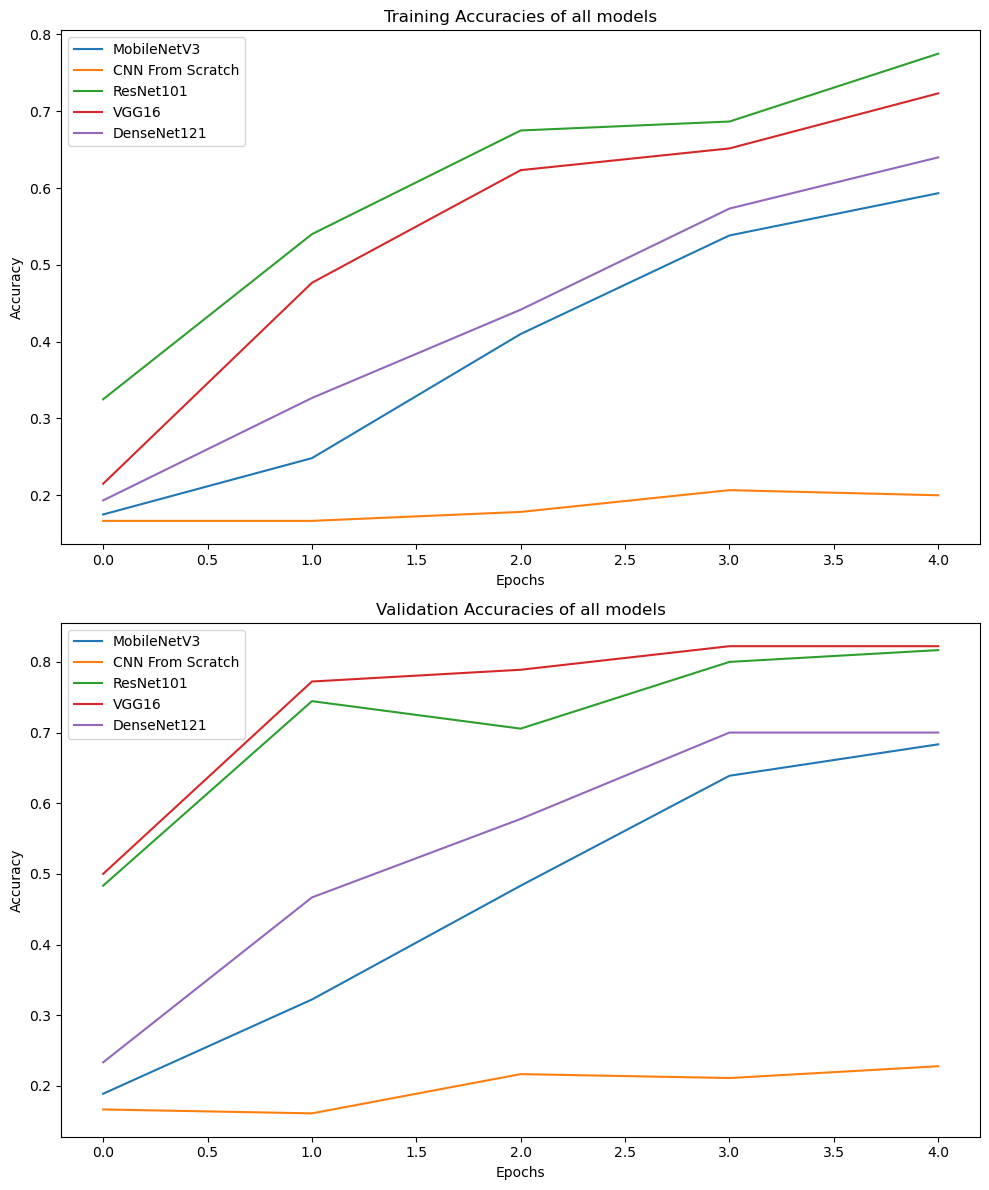

In [37]:
import matplotlib.pyplot as plt

def plot_losses(model_dict):
    fig, axs = plt.subplots(2, figsize=(10, 12))

    for model_object in model_dict.items():
        model_name = model_object[0]
        train_loss = model_object[1][1][0]
        val_loss = model_object[1][1][2]

        axs[0].plot(train_loss, label=f'{model_name}')
        axs[1].plot(val_loss, label=f'{model_name}')

    axs[0].set_title('Training Losses of all models')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].set_title('Validation Losses of all models')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_accuracies(model_dict):
    fig, axs = plt.subplots(2, figsize=(10, 12))

    for model_object in model_dict.items():
        model_name = model_object[0]
        train_acc = model_object[1][1][1]
        val_acc = model_object[1][1][3]

        axs[0].plot(train_acc, label=f'{model_name}')
        axs[1].plot(val_acc, label=f'{model_name}')

    axs[0].set_title('Training Accuracies of all models')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].set_title('Validation Accuracies of all models')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_losses(model_dict)
plot_accuracies(model_dict)

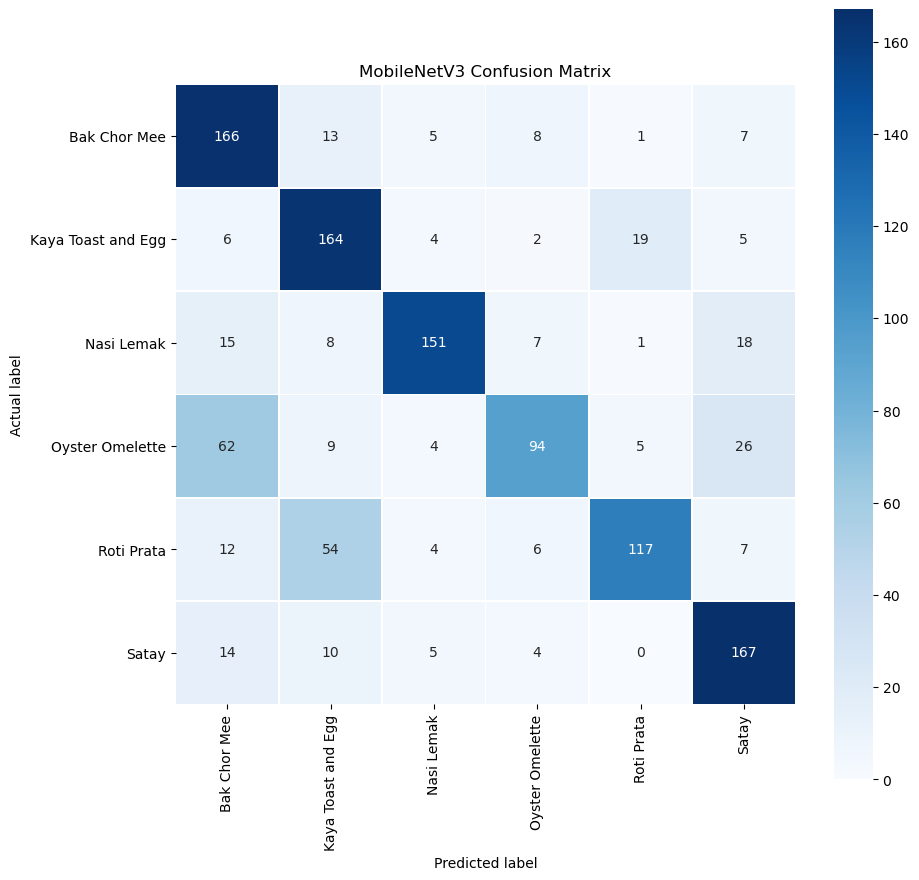

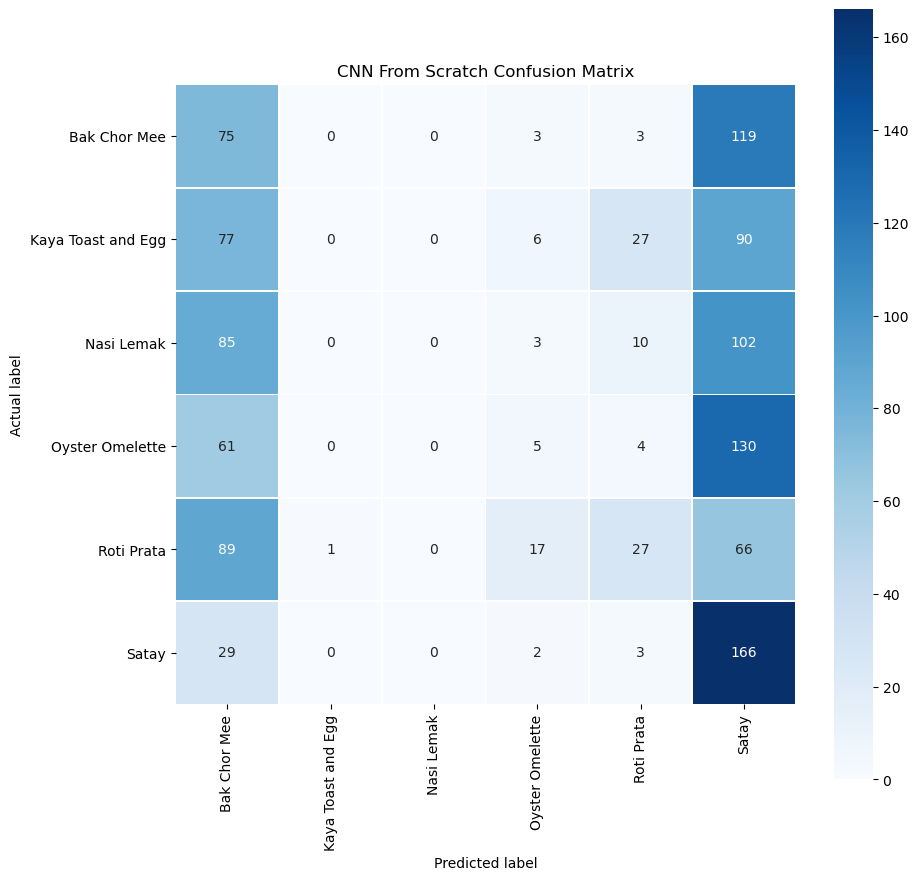

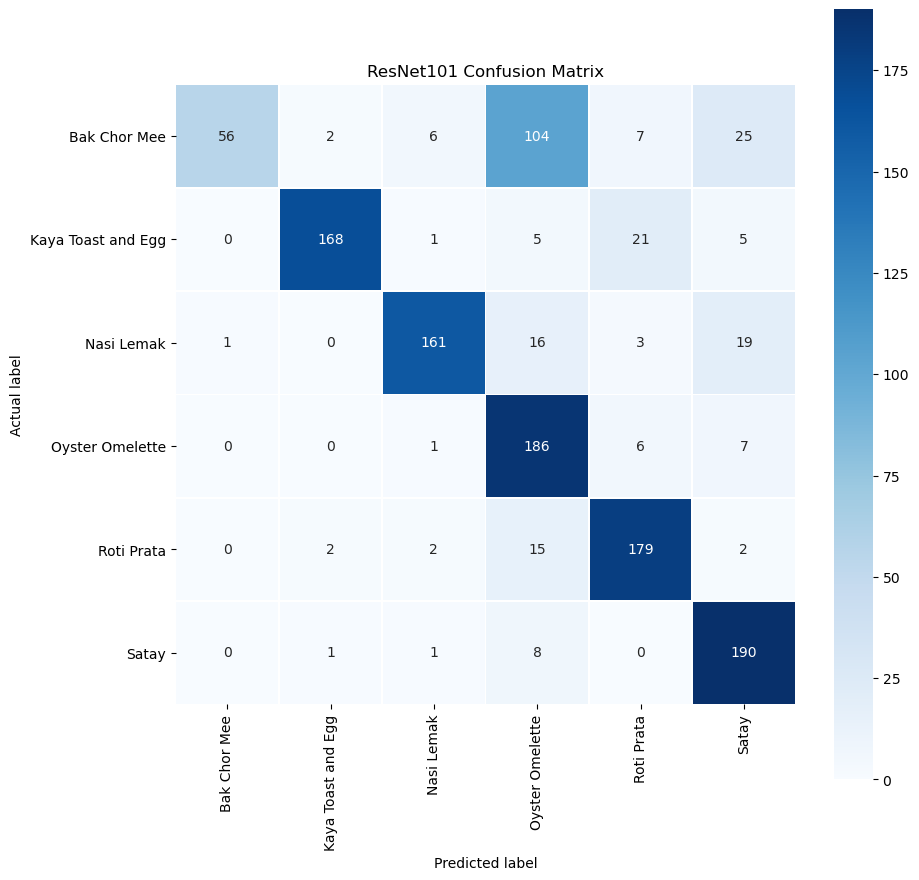

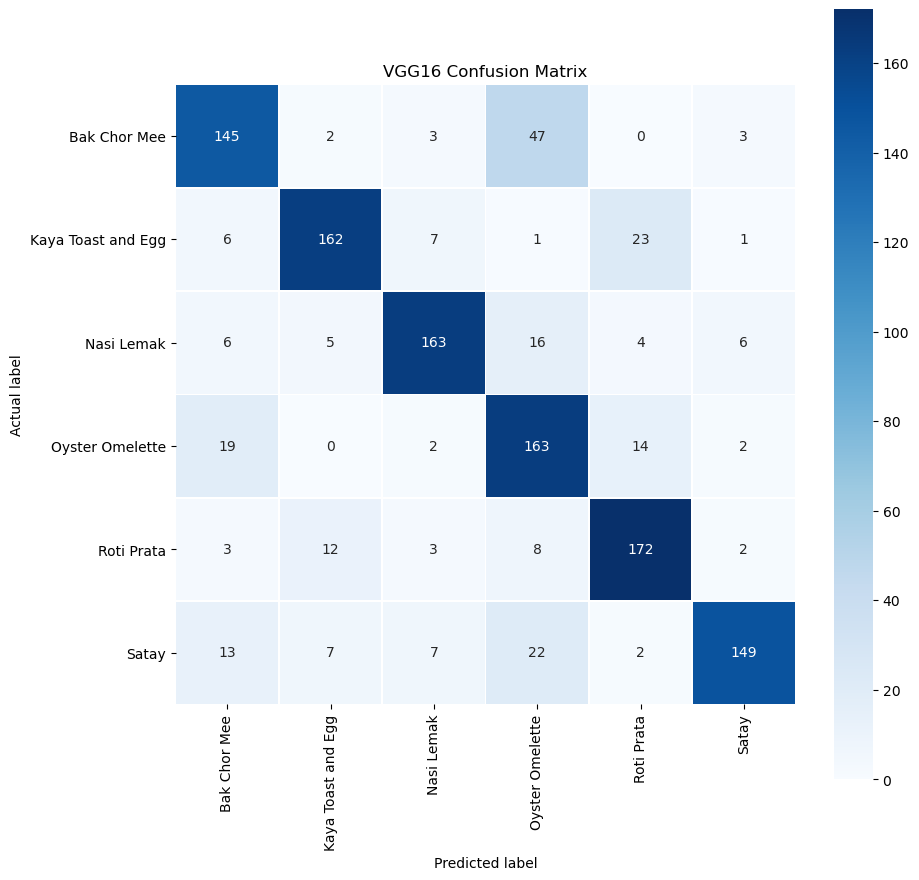

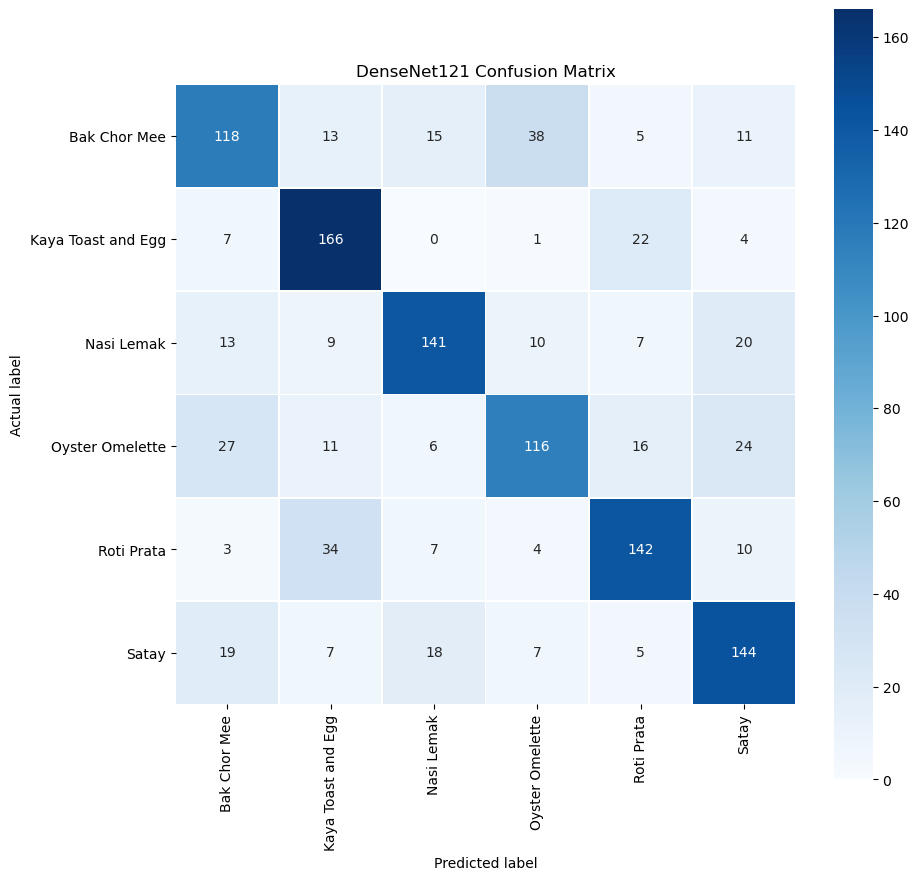

In [38]:
for model_object in model_dict.items():
    model_name = model_object[0]
    model = model_object[1][0]
    losses = model_object[1][1]
    all_preds = model_object[1][2][0]
    all_labels = model_object[1][2][1]
    train_loss = losses[0]
    train_acc = losses[1]
    val_loss = losses[2]
    val_acc = losses[3]

    # plot confusion matrix
    plot_confusion_matrix(model_name, all_preds, all_labels)


***

# 8. Advanced Requirements

For the advanced requirements, MobileNetV3 will be used as the baseline as the accuracy is one of the lowest, hence we have more room for improvement.

## Threshold setting

Designing the network to handle cases where the test food images do not belong to any of the 5 target food categories.

In [39]:
def classify_with_threshold(model, dataloader, threshold=0.7):
    model.eval()
    predictions = []
    confidences = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, 1)
            
            # Apply threshold
            unknown_mask = max_probs < threshold
            preds[unknown_mask] = -1  # Label -1 for 'unknown'
            
            predictions.extend(preds.cpu().numpy())
            confidences.extend(max_probs.cpu().numpy())
    
    return predictions, confidences

In [40]:
# Example usage:
threshold = 0.5  # You may need to tune this threshold
predictions, confidences = classify_with_threshold(model_mobilenet, test_loader, threshold)

# Analyze the output
print("Predictions:", predictions)
print("Confidences:", confidences)

Predictions: [-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 4, -1, -1, -1, -1, -1, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 

In [41]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid

def visualize_predictions_with_threshold(model, dataloader, threshold=0.7, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, 1)
            
            # Apply threshold
            preds[max_probs < threshold] = -1  # Set to -1 if below threshold
            
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]] if preds[j] != -1 else "Unknown"}\nActual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    print(f"Threshold used: {threshold}")
                    plt.show()
                    return


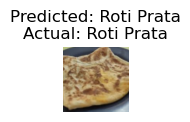

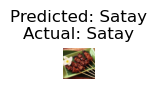

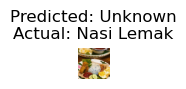

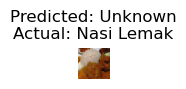

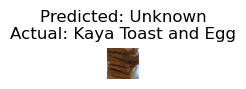

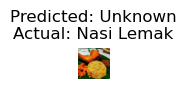

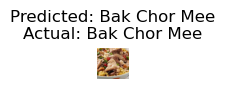

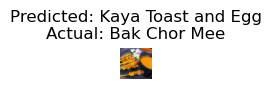

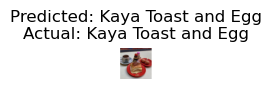

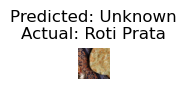

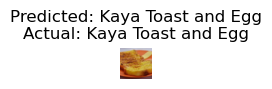

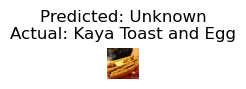

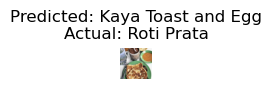

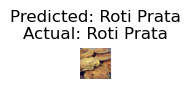

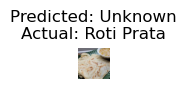

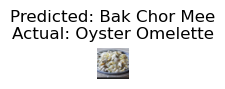

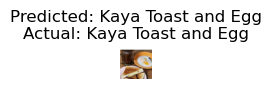

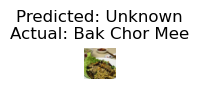

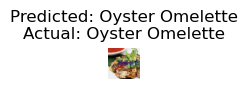

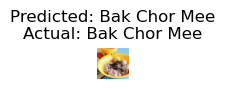

Threshold used: 0.3


In [42]:
# Assuming 'model_mobilenet' is your trained model and 'test_loader' is set up
threshold = 0.3  # Set a specific threshold
visualize_predictions_with_threshold(model_mobilenet, test_loader, threshold=threshold, num_images=20)


### Data Augmentation

Lets explore more ways of data augmentation to improve the accuracy of the network.

In [43]:
# Global Variables
data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}
selected_classes = [0,4,6,7,9,10]
n_classes = len(selected_classes)
num_epochs = 5

In [44]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Crop the given image to random size.
        transforms.RandomResizedCrop(224),
        # Horizontally flip the given image randomly with a given probability (default is 0.5).
        transforms.RandomHorizontalFlip(),  
        # Rotate the image by a random angle between (-degrees, +degrees). In this case, the image is rotated by an angle between -10 and +10 degrees.
        transforms.RandomRotation(10),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



# Define the dataset
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 4, 6, 7, 9, 10]
    name: ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']


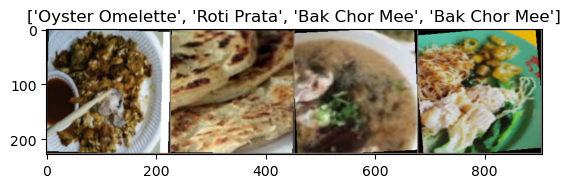

In [45]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

Retraining the network with the new data augmentation techniques.

In [46]:
import torchvision.models
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv = torchvision.models.mobilenet_v3_large(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


# 2. Modify the pretrain model for your task.

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[3].in_features
model_conv.classifier[3] = nn.Linear(num_ftrs, len(selected_classes))

model_conv = model_conv.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[3].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [47]:
model_mobilenet, losses_mobilenet = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/4
----------


train Loss: 1.7764 Acc: 0.2150
val Loss: 1.7748 Acc: 0.2056

Epoch 1/4
----------
train Loss: 1.6908 Acc: 0.2983
val Loss: 1.6283 Acc: 0.3333

Epoch 2/4
----------
train Loss: 1.6192 Acc: 0.3883
val Loss: 1.4735 Acc: 0.5111

Epoch 3/4
----------
train Loss: 1.4988 Acc: 0.5017
val Loss: 1.3312 Acc: 0.6611

Epoch 4/4
----------
train Loss: 1.4066 Acc: 0.5767
val Loss: 1.2081 Acc: 0.7778

Training complete in 1m 38s
Best val Acc: 0.777778


<div class="alert alert-block alert-success">
<b>Accuracy improved!</b> Exploring more methods of data augmentation improved the Validation Accuracy from 0.683 to 0.778.
</div>

## Improving the accuracy of the network

### Training more layers of the pretrained model

Lets try to improve the accuracy of the network by unfreezing the later layers of the network and training the network again.

In [48]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}


# Define the dataset
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 4, 6, 7, 9, 10]
    name: ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']


In [49]:
import torchvision.models
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv = torchvision.models.mobilenet_v3_large(pretrained=True)
# Unfreeze some of the later layers of the model
for param in model_conv.features[-5:].parameters():
    param.requires_grad = True


# 2. Modify the pretrain model for your task.

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[3].in_features
model_conv.classifier[3] = nn.Linear(num_ftrs, len(selected_classes))

model_conv = model_conv.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD([
    {'params': model_conv.features[-5:].parameters(), 'lr': 0.001},
    {'params': model_conv.classifier.parameters(), 'lr': 0.01}
], momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [50]:
model_mobilenet, losses_mobilenet = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/4
----------


train Loss: 1.6540 Acc: 0.3367
val Loss: 1.1781 Acc: 0.6778

Epoch 1/4
----------
train Loss: 1.0774 Acc: 0.6967
val Loss: 0.6565 Acc: 0.8556

Epoch 2/4
----------
train Loss: 0.7336 Acc: 0.7683
val Loss: 0.4806 Acc: 0.8833

Epoch 3/4
----------
train Loss: 0.6182 Acc: 0.8000
val Loss: 0.4455 Acc: 0.8667

Epoch 4/4
----------
train Loss: 0.5442 Acc: 0.8133
val Loss: 0.4139 Acc: 0.8611

Training complete in 3m 38s
Best val Acc: 0.883333


<div class="alert alert-block alert-success">
<b>Accuracy improved!</b> Unfreezing more layers of the pretrained network improved the Validation Accuracy of the network from 0.683 to 0.883. However, it extended the training time by about 2 minutes.
</div>

However, the training time took a hit. It took 4.5 times more time to train the network with more layers unfrozen.

## Speed up training process

Since the previous model took a lot of time to train, lets try to speed up the training process by changing the batch size

In [51]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}


# Define the dataset
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 128
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 4, 6, 7, 9, 10]
    name: ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']


In [52]:
import torchvision.models
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

model_conv = torchvision.models.mobilenet_v3_large(pretrained=True)
# Unfreeze some of the later layers of the model
for param in model_conv.features[-5:].parameters():
    param.requires_grad = True


# 2. Modify the pretrain model for your task.

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[3].in_features
model_conv.classifier[3] = nn.Linear(num_ftrs, len(selected_classes))

model_conv = model_conv.to(device)

# 3. Choose your loss function, optimizer, etc.

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD([
    {'params': model_conv.features[-5:].parameters(), 'lr': 0.001},
    {'params': model_conv.classifier.parameters(), 'lr': 0.01}
], momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [53]:
model_mobilenet, losses_mobilenet = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/4
----------


train Loss: 1.7697 Acc: 0.2183
val Loss: 1.5822 Acc: 0.4389

Epoch 1/4
----------
train Loss: 1.4988 Acc: 0.4817
val Loss: 1.1915 Acc: 0.6944

Epoch 2/4
----------
train Loss: 1.1458 Acc: 0.6833
val Loss: 0.8855 Acc: 0.7667

Epoch 3/4
----------
train Loss: 0.9066 Acc: 0.7500
val Loss: 0.6996 Acc: 0.7944

Epoch 4/4
----------
train Loss: 0.7954 Acc: 0.7683
val Loss: 0.5856 Acc: 0.8167

Training complete in 3m 38s
Best val Acc: 0.816667


<div class="alert alert-block alert-danger">
<b>Accuracy reduced.</b> The accuracy reduced slightly from 0.883 to 0.817 after changing the batch size from 64 to 128. This could be due to the fact that the network is not able to learn as well with a larger batch size.
</div>

***

### Model 5: InceptionV3

Since inception requires an input size of 299x299, we will resize the images accordingly.

In [54]:
data_input_size=299

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(data_input_size),  
        transforms.CenterCrop(data_input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(data_input_size),
        transforms.CenterCrop(data_input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(data_input_size),  
        transforms.CenterCrop(data_input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}


data_dir = os.path.join('data/sg_food')
subfolder = {'train': 'train', 'val': 'val','test':'test'}

# Define the dataset
selected_classes = [0,4,6,7,9,10]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 4, 6, 7, 9, 10]
    name: ['Bak Chor Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata', 'Satay']


In [70]:
import torch
import torchvision
from torchvision import models, transforms

# Load the pre-trained Inception v3 model
pretrained_model = models.inception_v3(pretrained=True)

# Freeze all the parameters in the feature extraction layers
for param in pretrained_model.parameters():
    param.requires_grad = False

num_ftrs = pretrained_model.fc.in_features

# Modify the final fully connected layer (fc) to match the number of classes
pretrained_model.fc = torch.nn.Linear(num_ftrs, n_classes)  # n_classes = 6 in your case

# Move the model to the GPU if available
inception = pretrained_model.to(device)

import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(inception.fc.parameters(), lr=0.001)

num_classes = 6  # For your 5 classes + 1 "others" class

# Modify the final fully connected layer of the main classifier
pretrained_model.fc = torch.nn.Linear(pretrained_model.fc.in_features, num_classes)

# If your model includes auxiliary classifiers, you should modify them too
if hasattr(pretrained_model, 'AuxLogits'):
    pretrained_model.AuxLogits.fc = torch.nn.Linear(pretrained_model.AuxLogits.fc.in_features, num_classes)

print("Training InceptionV3...")


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

# Initialize lists to store training and validation accuracy and loss
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

since = time.time()
for epoch in range(num_epochs):
    pretrained_model.train()  # Set model to training mode
    # Training
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs, aux_outputs = pretrained_model(inputs)

        # Calculate the loss
        loss1 = criterion(outputs, labels)  # Loss from main output
        loss2 = criterion(aux_outputs, labels)  # Loss from auxiliary output
        loss = loss1 + 0.4 * loss2  # Total loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_accuracy = correct / total

    # Save accuracy and loss for this epoch
    train_acc_history.append(epoch_accuracy)
    train_loss_history.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

    # Validation
    pretrained_model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloaders['val'].dataset)
    epoch_accuracy = correct / total

    # Save accuracy and loss for this epoch
    val_acc_history.append(epoch_accuracy)
    val_loss_history.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_accuracy:.4f}')

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

# Combine the lists into one list of tuples
history = [train_loss_history, train_acc_history, val_loss_history, val_acc_history]
print(history)

Training InceptionV3...


Epoch [1/5], Train Loss: 2.4771, Train Accuracy: 0.2150
Epoch [1/5], Val Loss: 1.6527, Val Accuracy: 0.2833
Epoch [2/5], Train Loss: 2.0590, Train Accuracy: 0.4517
Epoch [2/5], Val Loss: 1.4441, Val Accuracy: 0.5278
Epoch [3/5], Train Loss: 1.7744, Train Accuracy: 0.5900
Epoch [3/5], Val Loss: 1.3185, Val Accuracy: 0.6611
Epoch [4/5], Train Loss: 1.5749, Train Accuracy: 0.6300
Epoch [4/5], Val Loss: 1.2089, Val Accuracy: 0.7111
Epoch [5/5], Train Loss: 1.4015, Train Accuracy: 0.7100
Epoch [5/5], Val Loss: 1.1127, Val Accuracy: 0.7278
Training complete in 5m 45s
[[2.4770826784769695, 2.0589955202738444, 1.774381823539734, 1.5748826487859091, 1.4014587338765463], [0.215, 0.45166666666666666, 0.59, 0.63, 0.71], [1.6526985883712768, 1.4440820217132568, 1.3184568961461385, 1.208905159102546, 1.112665671772427], [0.2833333333333333, 0.5277777777777778, 0.6611111111111111, 0.7111111111111111, 0.7277777777777777]]


In [71]:
# append the model and history to the model_dict
model_dict['InceptionV3'] = [pretrained_model, history]

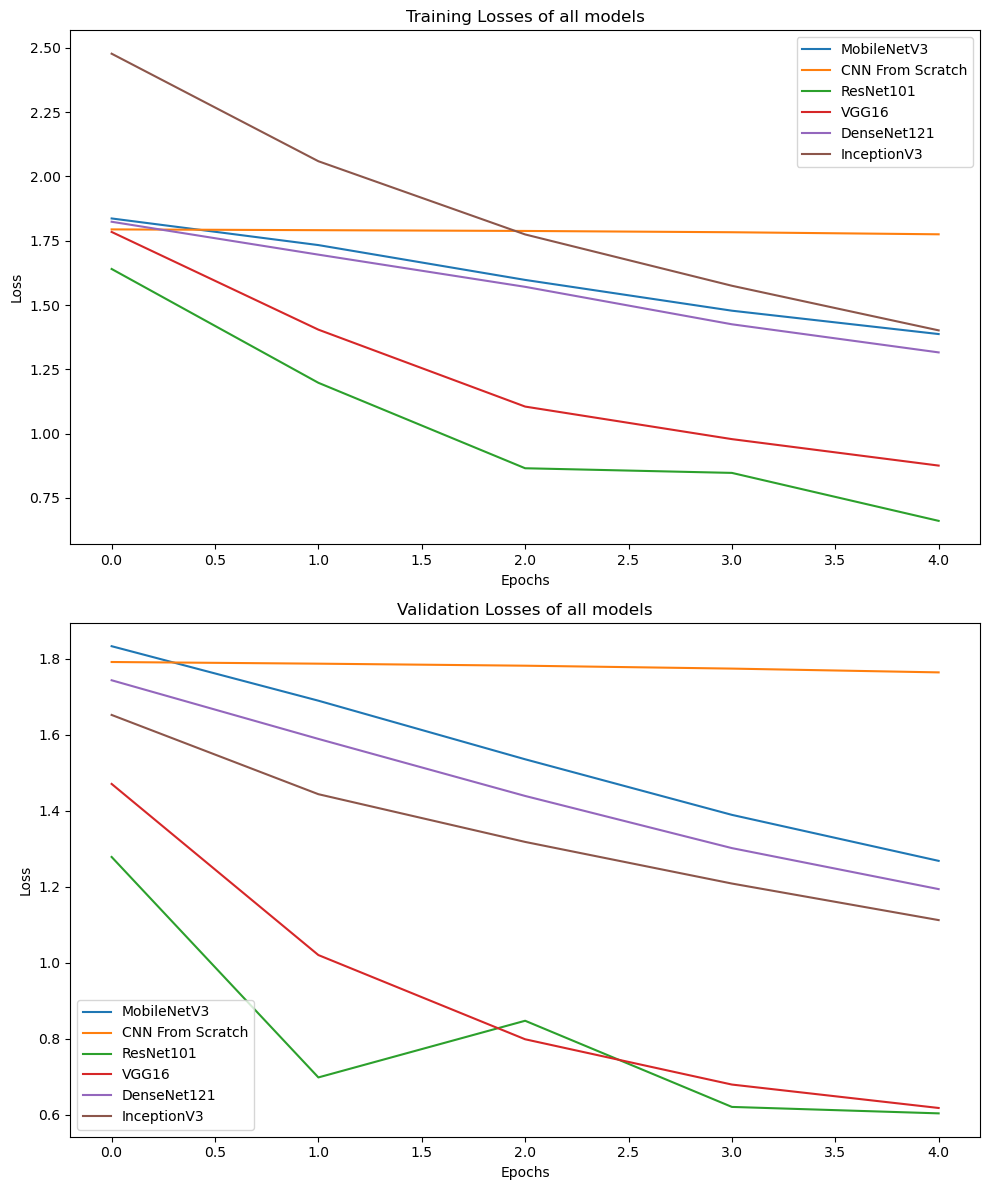

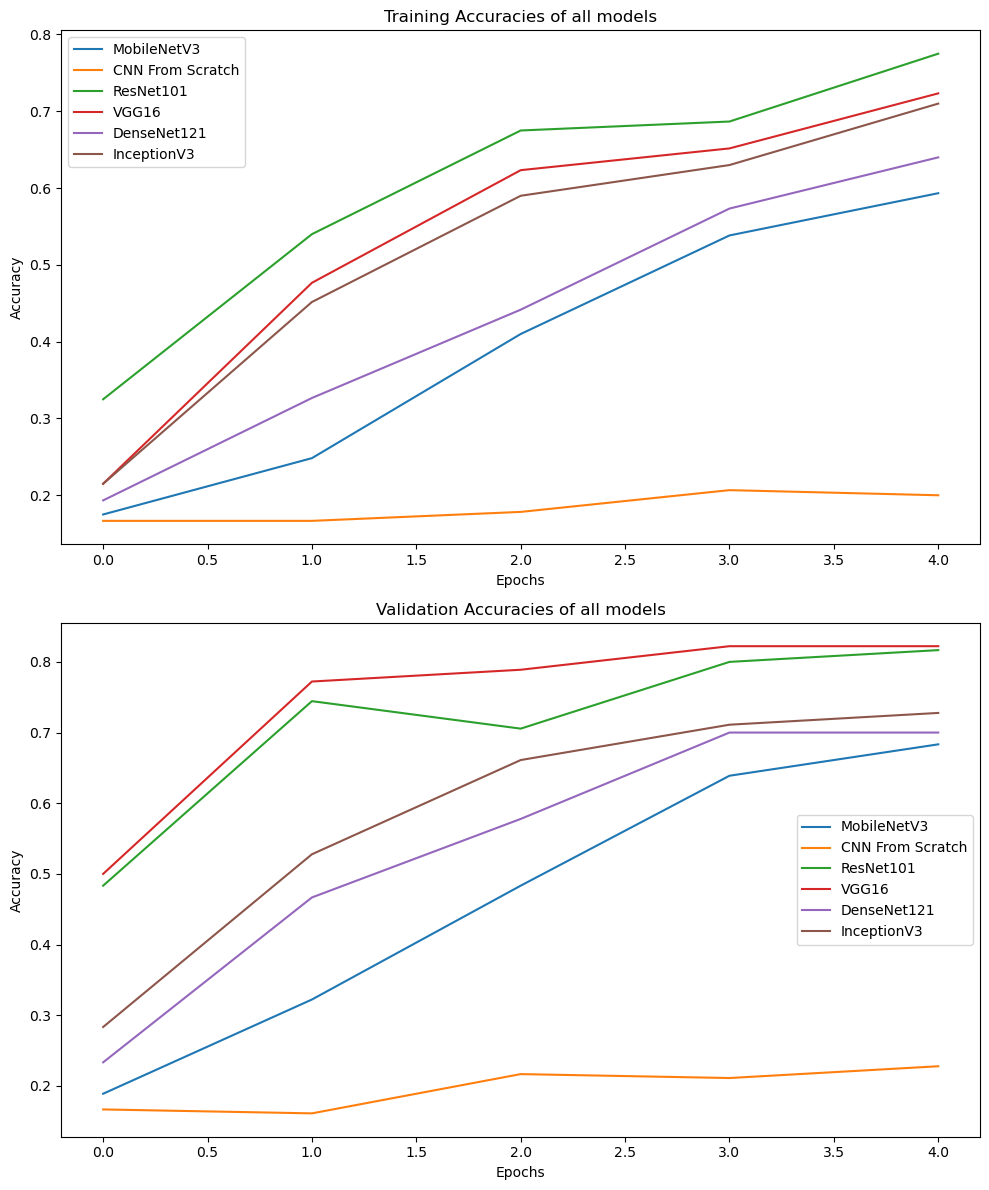

In [72]:
# plot the losses and accuracies of all the models
plot_losses(model_dict)
plot_accuracies(model_dict)

In [59]:
print(pretrained_model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [60]:
from torchsummary import summary
summary(pretrained_model,input_size=(3, 299, 299))

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       (864)
|    └─BatchNorm2d: 2-2                  (64)
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-3                       (9,216)
|    └─BatchNorm2d: 2-4                  (64)
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-5                       (18,432)
|    └─BatchNorm2d: 2-6                  (128)
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-7                       (5,120)
|    └─BatchNorm2d: 2-8                  (160)
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-9                       (138,240)
|    └─BatchNorm2d: 2-10                 (384)
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
|    └─BasicConv2d: 2-11                 --
|    |    └─Conv2d: 3-1                  (12,288)
|    |    └─BatchNorm2d: 3

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       (864)
|    └─BatchNorm2d: 2-2                  (64)
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-3                       (9,216)
|    └─BatchNorm2d: 2-4                  (64)
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-5                       (18,432)
|    └─BatchNorm2d: 2-6                  (128)
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-7                       (5,120)
|    └─BatchNorm2d: 2-8                  (160)
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-9                       (138,240)
|    └─BatchNorm2d: 2-10                 (384)
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
|    └─BasicConv2d: 2-11                 --
|    |    └─Conv2d: 3-1                  (12,288)
|    |    └─BatchNorm2d: 3

In [62]:
test_dir = os.path.join('data','sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

True labels:  ['Kaya Toast and Egg', 'Oyster Omelette', 'Nasi Lemak', 'Kaya Toast and Egg']
Predictions:  ['Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata', 'Kaya Toast and Egg']


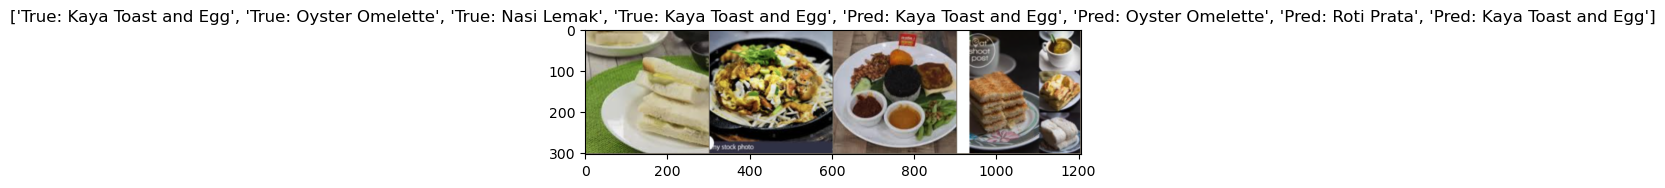

In [63]:

num_images = 4
inputs, classes = next(iter(dataloaders['val']))
inputs = inputs.to(device)
classes = classes.to(device)

with torch.no_grad():
    inception.eval()  # Make sure the model is in evaluation mode.
    outputs = inception(inputs)
    _, preds = torch.max(outputs, 1)

# Get the first `num_images` images
inputs = inputs[:num_images]
preds = preds[:num_images]
classes = classes[:num_images]

# Convert images and predictions
inputs = inputs.cpu()
preds = preds.cpu()

print("True labels: ", [class_names[x] for x in classes])
print("Predictions: ", [class_names[x] for x in preds])

# Make a grid from batch and show
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[f"True: {class_names[x]}" for x in classes] +
                  [f"Pred: {class_names[x]}" for x in preds])

In [64]:
pretrained_model.eval()  # Set model to evaluate mode
correct = 0
total = 0

pretrained_model.zero_grad()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = inception(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test images: {100 * correct / total:.2f}%')


Accuracy on the test images: 75.67%


***

# Conclusion

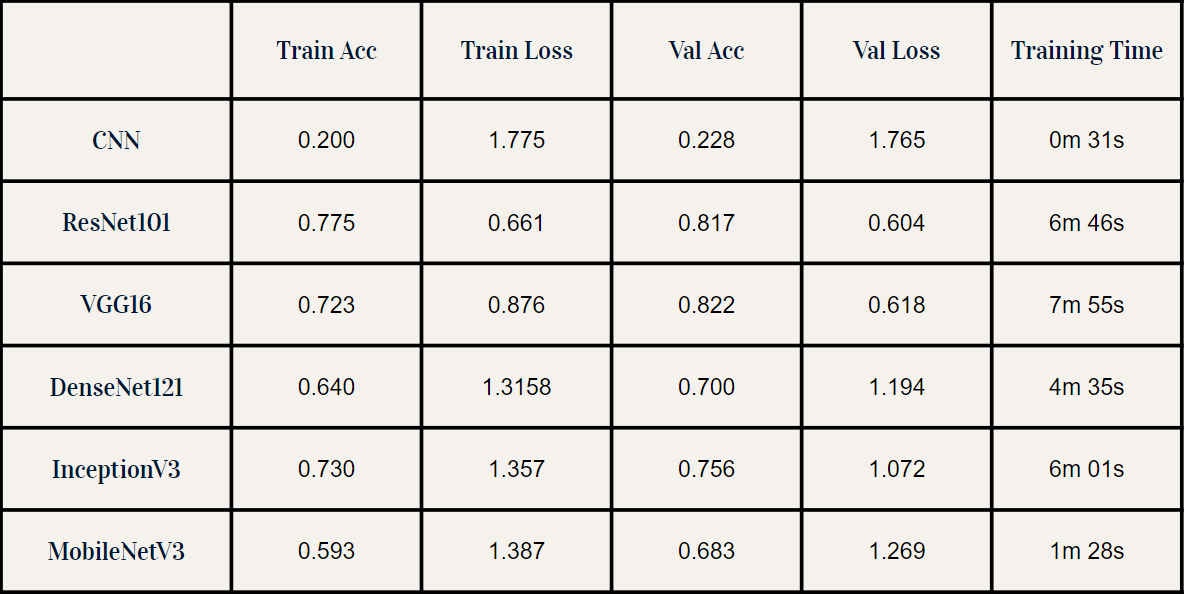

The table above compares the performance of the models. Here’s a summary and explanation of the results:

**CNN:** This custom model had the lowest training accuracy (Train Acc) and validation accuracy (Val Acc) at 0.200 and 0.228, respectively, indicating it might be underfitting or not complex enough for the task. Its training time was the shortest, which is expected for a simpler, smaller, custom model.

**ResNet101:** It performed quite well, with high training (0.775) and validation accuracies (0.817), suggesting that it learned the task effectively. It had a moderate training time of just under 7 minutes, a reasonable trade-off for its good performance. ResNet feature residual connections that allow gradients to flow through the network more effectively, mitigating the vanishing gradient problem in deep networks which may have contributed to its good performance.

**VGG16:** This network also showed strong performance, with training and validation accuracies above 0.7. It had the longest training time of nearly 8 minutes. VGG16's architecture uses 3x3 convolution filters throughout, which creates a large number of trainable parameters. This depth and capacity enable it to learn complex features, contributing to its high accuracy, but also result in longer training times due to the computational overhead of many convolutional layers

**DenseNet121:** With a training accuracy of 0.640 and validation accuracy of 0.700, it performed decently but took significantly less time to train than VGG16. Its architecture allows for feature reuse, which can be computationally efficient. DenseNet architectures use densely connected layers where each layer receives input from all preceding layers, fostering feature reuse and reducing the number of parameters. This leads to efficient training and inference, which explains the decent accuracy and shorter training time compared to the deeper VGG16

**InceptionV3:** It demonstrated good training and validation accuracies, indicating it was capable of learning the task well. Its training time was just over 6 minutes, making it a balanced choice in terms of performance and time. Inception architecture uses modules with parallel convolutions of different sizes, allowing it to capture features at various scales and complexities. InceptionV3 optimizes computational resource use by factorizing convolutions and using batch normalization, which contributes to good performance with a relatively short training duration.

**MobileNetV3:** While its accuracies were lower than some other models (0.593 train, 0.683 val), it trained extremely quickly at just 1 minute and 28 seconds.  This is in line with its design as a mobile-friendly network, prioritizing speed and efficiency. MobileNetV3 includes optimizations like the squeeze-and-excitation blocks and the hard-swish activation function, which improve efficiency. Its architecture is the main reason for the shortest training time and good enough performance for many real-world applications, despite having lower accuracy compared to the larger models.

***